Importing the Dependencies

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

Data Collection & Pre-processing

In [52]:
# importing the dataset to Pandas Dataframe
dataset = pd.read_csv("/content/airline-passengers.csv",usecols=[1],engine='python')
dataset.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [53]:
# no. of rows and columns
dataset.shape

(144, 1)

In [54]:
# checking empty values in dataset
dataset.isnull().sum()

,0
Passengers,0


In [55]:
# All random operations in TensorFlow will now produce the same output every time you run the code
tf.random.set_seed(7001)

In [56]:
# converting dataset to numpy array
dataset = dataset.values.astype('float32')
print(type(dataset))

<class 'numpy.ndarray'>


In [57]:
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

Data Scaling

In [58]:
# Scaling the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

Data Splitting

In [59]:
# Splitting the data into train data and test data
train, test = train_test_split(dataset, test_size=0.33, shuffle=False)
print("Training data: ",train)
print("Testing data: ",test)

Training data:  [[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.

Function to create 2 numpy arrays:



*   dataX which stores the past look_back no. of values
*   dataY which stores the next value



In [60]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

Building LSTM Model


In [61]:
def build_bi_lstm_model(units=50, look_back=1, optimizer='adam', learning_rate=0.001, loss='mse'):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='tanh'), input_shape=(look_back, 1)))
    model.add(Dense(1))

    if optimizer=='adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer=='sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=opt)
    return model

The evaluate_model function trains an LSTM with given hyperparameters on the training data, predicts on the test data, and returns the model’s RMSE as a measure of performance.

In [62]:
def evaluate_model(units, batch_size, epochs, optimizer, look_back, learning_rate):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY   = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX  = np.reshape(testX,  (testX.shape[0],  testX.shape[1],  1))

    model = build_bi_lstm_model(units=units, look_back=look_back, optimizer=optimizer, learning_rate=learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    model.fit(trainX, trainY,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(testX, testY),
              verbose=0,
              callbacks=[early_stop])

    testPredict = model.predict(testX, verbose=0)
    testPredict = scaler.inverse_transform(testPredict)
    testY_rescaled = scaler.inverse_transform([testY])
    rmse = np.sqrt(mean_squared_error(testY_rescaled[0], testPredict[:,0]))
    return rmse

Random Search

Evaluating model metric: RMSE for different random sets of hyperparameters and storing them

In [63]:
param_grid = {
    'units': [16, 32, 64],
    'batch_size': [4, 8, 16],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'look_back': [3, 5, 10],
    'learning_rate': [1e-3, 3e-3]
}

n_iter = 5
results = []

for i in range(n_iter):
    params = {key: random.choice(values) for key, values in param_grid.items()}
    rmse = evaluate_model(**params)
    results.append((params, rmse))
    print(f"Trial {i+1}: Params={params}, RMSE={rmse:.2f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 1: Params={'units': 16, 'batch_size': 4, 'epochs': 100, 'optimizer': 'adam', 'look_back': 3, 'learning_rate': 0.001}, RMSE=64.30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 2: Params={'units': 64, 'batch_size': 16, 'epochs': 50, 'optimizer': 'adam', 'look_back': 5, 'learning_rate': 0.003}, RMSE=85.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 3: Params={'units': 16, 'batch_size': 8, 'epochs': 100, 'optimizer': 'adam', 'look_back': 5, 'learning_rate': 0.003}, RMSE=70.34


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 4: Params={'units': 16, 'batch_size': 8, 'epochs': 100, 'optimizer': 'rmsprop', 'look_back': 10, 'learning_rate': 0.001}, RMSE=58.88


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trial 5: Params={'units': 64, 'batch_size': 8, 'epochs': 50, 'optimizer': 'rmsprop', 'look_back': 5, 'learning_rate': 0.001}, RMSE=86.65


Saving Random Search results in a csv file

In [64]:
with open('random_search_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['units','batch_size','epochs','optimizer','look_back','learning_rate','rmse'])
    for params, rmse in results:
        writer.writerow([params['units'], params['batch_size'], params['epochs'], params['optimizer'], params['look_back'], params['learning_rate'], rmse])

Selecting Best Model with least RMSE value

In [65]:
best_params, best_rmse = min(results, key=lambda x: x[1])
print("\nBest Parameters:", best_params)
print("Best RMSE:", best_rmse)


Best Parameters: {'units': 16, 'batch_size': 8, 'epochs': 100, 'optimizer': 'rmsprop', 'look_back': 10, 'learning_rate': 0.001}
Best RMSE: 58.87859483461405


Building the LSTM model with selected hyperparameters

In [66]:
best_look_back = best_params['look_back']
best_model = build_bi_lstm_model(units=best_params['units'],
                                 look_back=best_look_back,
                                 optimizer=best_params['optimizer'],
                                 learning_rate=best_params['learning_rate'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the LSTM model

In [67]:
trainX, trainY = create_dataset(train, best_look_back)
testX, testY   = create_dataset(test, best_look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX  = np.reshape(testX,  (testX.shape[0],  testX.shape[1],  1))

early_stop = EarlyStopping(monitor='val_loss', patience=5)
best_model.fit(trainX, trainY,
               epochs=best_params['epochs'],
               batch_size=best_params['batch_size'],
               validation_data=(testX, testY),
               verbose=2,
               callbacks=[early_stop])

Epoch 1/100
11/11 - 4s - 373ms/step - loss: 0.0534 - val_loss: 0.2174
Epoch 2/100
11/11 - 0s - 22ms/step - loss: 0.0167 - val_loss: 0.1184
Epoch 3/100
11/11 - 0s - 17ms/step - loss: 0.0114 - val_loss: 0.0932
Epoch 4/100
11/11 - 0s - 15ms/step - loss: 0.0097 - val_loss: 0.0762
Epoch 5/100
11/11 - 0s - 28ms/step - loss: 0.0084 - val_loss: 0.0608
Epoch 6/100
11/11 - 0s - 28ms/step - loss: 0.0073 - val_loss: 0.0489
Epoch 7/100
11/11 - 0s - 16ms/step - loss: 0.0066 - val_loss: 0.0407
Epoch 8/100
11/11 - 0s - 18ms/step - loss: 0.0062 - val_loss: 0.0355
Epoch 9/100
11/11 - 0s - 15ms/step - loss: 0.0059 - val_loss: 0.0322
Epoch 10/100
11/11 - 0s - 27ms/step - loss: 0.0058 - val_loss: 0.0302
Epoch 11/100
11/11 - 0s - 17ms/step - loss: 0.0057 - val_loss: 0.0290
Epoch 12/100
11/11 - 0s - 26ms/step - loss: 0.0056 - val_loss: 0.0281
Epoch 13/100
11/11 - 0s - 28ms/step - loss: 0.0056 - val_loss: 0.0275
Epoch 14/100
11/11 - 0s - 27ms/step - loss: 0.0055 - val_loss: 0.0271
Epoch 15/100
11/11 - 0s - 17

 Forecast next 12 months

In [68]:
future_steps = 12
last_seq = dataset[-best_look_back:]
future_preds = []

for _ in range(future_steps):
    seq_input = np.reshape(last_seq, (1, best_look_back, 1))
    pred = best_model.predict(seq_input, verbose=0)
    future_preds.append(pred[0,0])
    last_seq = np.append(last_seq[1:], pred[0,0])

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
print("Next 12 months forecast:\n", future_preds.flatten())

Next 12 months forecast:
 [448.17758 452.57724 456.1708  461.60083 463.98883 457.60284 446.59152
 438.65326 432.7109  433.64136 433.27747 432.30328]


Visualization of historical data and forecast


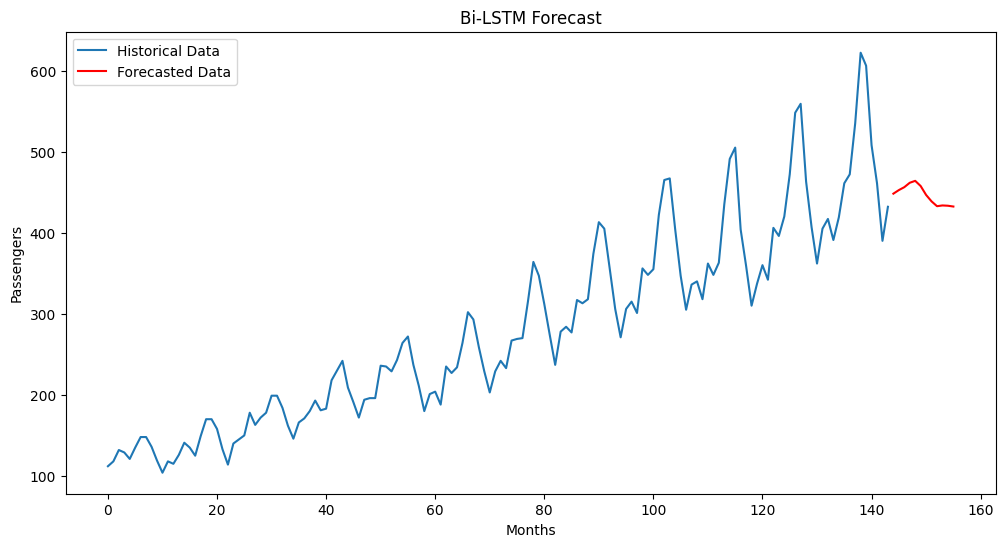

In [69]:
plt.figure(figsize=(12,6))
plt.plot(range(len(dataset)), scaler.inverse_transform(dataset), label="Historical Data")
plt.plot(range(len(dataset), len(dataset)+future_steps), future_preds, label="Forecasted Data", color='red')
plt.title("Bi-LSTM Forecast")
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.legend()
plt.show()